<a href="https://colab.research.google.com/github/zeligism/CubicOneShotSGD/blob/main/CubicOneShotSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [219]:
# Download a9a dataset
A9A_DATASET = "a9a.txt"
A9A_LINK = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
! [[ ! -f "{A9A_DATASET}" ]] && wget -O "{A9A_DATASET}" "{A9A_LINK}"
! head "{A9A_DATASET}"

-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 5:1 7:1 14:1 19:1 39:1 40:1 51:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 
-1 3:1 6:1 17:1 22:1 36:1 41:1 53:1 64:1 67:1 73:1 74:1 76:1 80:1 83:1 
-1 5:1 6:1 17:1 21:1 35:1 40:1 53:1 63:1 71:1 73:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 18:1 19:1 39:1 40:1 52:1 61:1 71:1 72:1 74:1 76:1 80:1 95:1 
-1 3:1 6:1 18:1 29:1 39:1 40:1 51:1 61:1 67:1 72:1 74:1 76:1 80:1 83:1 
-1 4:1 6:1 16:1 26:1 35:1 45:1 49:1 64:1 71:1 72:1 74:1 76:1 78:1 101:1 
+1 5:1 7:1 17:1 22:1 36:1 40:1 51:1 63:1 67:1 73:1 74:1 76:1 81:1 83:1 
+1 2:1 6:1 14:1 29:1 39:1 42:1 52:1 64:1 67:1 72:1 75:1 76:1 82:1 83:1 
+1 4:1 6:1 16:1 19:1 39:1 40:1 51:1 63:1 67:1 73:1 75:1 76:1 80:1 83:1 


## Args

In [220]:
# Easy to transfer to code using argparse
class Args:
    def __init__(self):
        self.feature_dim = 123
        self.output_dim = 1
        self.dataset = "a9a"
        self.device = "cuda:0"
        self.num_models = 10
        self.num_iters = 200
        self.base_lr = 1e-2
        self.lrs = [self.base_lr] * self.num_models
        self.batch_size = 1

args = Args()

## Dataset

In [221]:
from sklearn.datasets import load_svmlight_file

class MyDataset(data_utils.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.X = None
        self.y = None

        if self.dataset == "a9a":
            with open(A9A_DATASET, "rb") as f:
                self.X, self.y = load_svmlight_file(f)
        else:
            raise Exception(f"Dataset '{self.dataset}' not found.")

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X_tensor = torch.Tensor(self.X[idx].todense()).squeeze(0)
        y_tensor = torch.Tensor([self.y[idx]]).squeeze(0)
        return X_tensor, y_tensor

class DataSampler:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.reset_sampler()

    def reset_sampler(self):
        self.sampler = iter(self.dataloader)

    def sample(self):
        try:
            x, y = next(self.sampler)
        except StopIteration:
            self.reset_sampler()
            x, y = next(self.sampler)
        return x, y

## Optimizer

In [222]:
class LocalSGD(torch.optim.SGD):
    def aggregate(self):
        # This function simply averages parameters across all groups/models
        num_models = len(self.param_groups)
        num_params = len(self.param_groups[0]["params"])
        aggregated_params = [None] * num_params
        # Find average per parameter
        for param_idx in range(num_params):
            param_list = [self.param_groups[model_idx]["params"][param_idx].data
                          for model_idx in range(num_models)]
            aggregated_params[param_idx] = torch.mean(torch.stack(param_list))
        # Synchronize
        for model_idx in range(num_models):
            for param_idx in range(num_params):
                self.param_groups[model_idx]["params"][param_idx] = aggregated_params[param_idx]

### Aggregation Schedule

In [223]:
# The schedule is just the iterations in which we aggregate
aggregation_idxs = { args.num_iters-1 }  # one-shot averaging
#aggregation_idxs = { range(0, args.num_iters-1, args.num_iters // 10) }  # 10-shot iters averaging

## Model

In [224]:
def create_model(model_idx):
    return nn.Sequential(
        nn.Linear(args.feature_dim, args.output_dim),
        nn.Tanh(),
    )

# Training

Train prep

In [225]:
dataset = MyDataset(args.dataset)
test_size = int(0.1 * len(dataset))
trainset, testset = data_utils.random_split(dataset, [len(dataset) - test_size, test_size])
trainloader = data_utils.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, pin_memory=True)
testloader = data_utils.DataLoader(testset, batch_size=len(testset), shuffle=False, pin_memory=True)

models = [create_model(i).to(device=args.device) for i in range(args.num_models)]
param_groups = [{"params": models[i].parameters(), "lr": args.lrs[i]} for i in range(args.num_models)]
optimizer = LocalSGD(param_groups, lr=args.base_lr)
loss_fn = nn.MSELoss().to(device=args.device)

In [226]:
def validate(testloader, models):
    # Validate a randomly selected model or all models?
    model = models[np.random.randint(len(models))]
    running_loss = 0.0
    running_acc = 0
    for x, y in testloader:
        x = x.to(device=args.device)
        y = y.to(device=args.device)
        y_pred = model(x).view_as(y)
        loss = loss_fn(y_pred, y)
        acc = torch.sum(y_pred.round() == y) / y.size(0)
        running_loss += loss.item()
        running_acc += acc.item()
    mean_loss = running_loss / len(testloader)
    mean_acc = running_acc / len(testloader)
    return mean_loss, mean_acc

def train(trainloader, testloader, models,
          optimizer, loss_fn, aggregation_idxs, T):
    data_sampler = DataSampler(trainloader)
    stats = defaultdict(list)
    running_loss = 0.0
    for t in range(T):
        # model loop should be run in parallel
        for model in models:
            x, y = data_sampler.sample() # assuming a central dataset
            x = x.to(device=args.device)
            y = y.to(device=args.device)
            y_pred = model(x).view_as(y)
            loss = loss_fn(y_pred, y)
            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Aggregate the gradient steps by averaging the parameters
        if t in aggregation_idxs:
            optimizer.aggregate()
        
        # Validation
        train_loss = running_loss / ((t+1) * len(models))
        val_loss, val_acc = validate(testloader, models)
        stats["train_loss"] += [train_loss]
        stats["val_loss"] += [val_loss]
        stats["val_acc"] += [val_acc]
        print(f"[{t}/{T}] train_loss = {train_loss:.4f}, "\
              f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}")
    
    return stats

stats = train(trainloader, testloader, models,
              optimizer, loss_fn, aggregation_idxs, args.num_iters)

[0/200] train_loss = 1.3382, val_loss = 0.8404, val_acc = 0.0046
[1/200] train_loss = 1.2876, val_loss = 0.7729, val_acc = 0.0353
[2/200] train_loss = 1.0929, val_loss = 0.7471, val_acc = 0.2647
[3/200] train_loss = 1.0102, val_loss = 1.0251, val_acc = 0.0000
[4/200] train_loss = 0.9659, val_loss = 0.6911, val_acc = 0.4819
[5/200] train_loss = 0.8986, val_loss = 0.6974, val_acc = 0.6096
[6/200] train_loss = 0.8271, val_loss = 0.6974, val_acc = 0.6422
[7/200] train_loss = 0.8038, val_loss = 0.7722, val_acc = 0.0697
[8/200] train_loss = 0.8009, val_loss = 0.6939, val_acc = 0.3925
[9/200] train_loss = 0.7764, val_loss = 0.6811, val_acc = 0.4828
[10/200] train_loss = 0.7916, val_loss = 0.7366, val_acc = 0.5989
[11/200] train_loss = 0.7863, val_loss = 0.9579, val_acc = 0.0000
[12/200] train_loss = 0.7610, val_loss = 0.7003, val_acc = 0.6529
[13/200] train_loss = 0.7477, val_loss = 0.7343, val_acc = 0.7067
[14/200] train_loss = 0.7255, val_loss = 0.6910, val_acc = 0.6754
[15/200] train_loss 

# Results

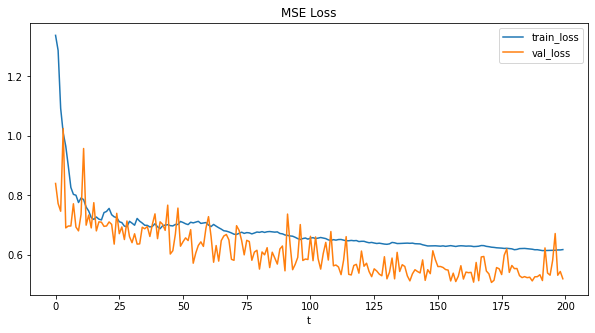

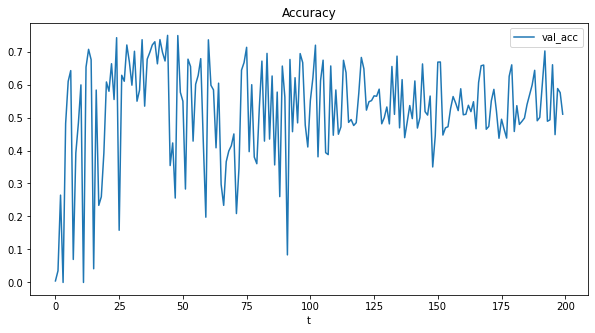

In [227]:
def plot_lines(losses_dict, title="", filename=None, ):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()

losses = {k: v for k, v in stats.items() if "loss" in k}
accuracies = {k: v for k, v in stats.items() if "acc" in k}
plot_lines(losses, "MSE Loss")
plot_lines(accuracies, "Accuracy")